# Synthetic $\ell$-v Diagram Generator

### By Juan Cabanela (Minnesota State University Moorhead)

This program is designed to allow you to model the neutral hydrogen line spectrum (a.k.a. the 21-cm line) as a function of galactic longitude of a model Milky Way galaxy as viewed from the Sun (assumed to be 8.5 kpc out from the center).  In other words, you are modelling the $\ell$-v diagram of the Milky Way.

This interactive interface initially loads the observed rotation curve and neutral gas density profile for the Milky Way and generates a synthetic $\ell$-v diagram.  You can interactively sketch a new rotation curve or gas density profile and the synthetic $\ell$-v diagram updates to reflect those changes.  You can also modify the gas velocity dispersion by sliding the slider labeled $\sigma_v$ and see the effect that has.

In [1]:
# Author: Juan Cabanela
#
# Originally written in perl (using pgplot libraries) in 2002, this could was ported to a python script 
# using matplotlib in 2013 (roughly) and in 2017 it was moved to a Jupyter notebook.  The current version
# was ported in summer 2019 to allow use of ipywidget widgets as controls for the l-v diagram generator.

In [2]:
# Import necessary libraries
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt

import random
import string
import numpy as np
import io
import sys
import bqplot as bq
from ipywidgets import Layout
from ipywidgets import widgets
from IPython.display import display

# Import specific functions designed for galaxy model building
from galaxyparam import *

In [3]:
### Configure some basic settings for this notebook here
#
# You will need to set up a few things before running this Jupyter notebook (the defaults are fine for the first run):
#
# Changing the galaxy model: You may want to edit galaxy_datafile with the filename of the file describing the 
#    galaxy.  That file must be in the same directory with the IPython notebook.  That file is a 3 column (where 
#    the columns are comma-seperated) text file.  The three columns are:
#
#    1. radius (in kpc): Radius of this data point in kpc
#    2. rot_vel (in km/s): Rotational velocity of this data point in km/s
#    3. density (in atoms/cm^3): Assumed gas density at this point (in atoms/cm^3)
#    The 'header' row is required to be "radius,rot_vel,density" or this script will not properly read the file.
#
#   After running the default realistic Milky Way model, you will create a new galaxy model (in a different file
#   than the original galaxy_description.csv) to represent a Keplerian (~ r^{-1/2}) rotation curve.  
#   You will need to set galaxy_datafile to point to the file containing the new model.  Don't worry about 
#   evenly spacing data points in radius.  The part of the script below that reads this datafile will 
#   interpolate between your radial points with a spline fit, so it is pretty robust as smoothly fitting 
#   between your data points.
#
# Changing the image filename: Set up the image_filename for the file you will want to save the final image.
#    It must end with .jpg, .png, or .pdf.

# Initialize filenames and parameters related to data import
galaxy_datafile = "data/galaxy_description.csv"  # File containing rotation curve and density data
HIradius = 25    # Assumed radius of HI disk
dens_drop = 0.01  # Drop in density per kpc of radius (in atoms/cm^3)
# Load the Galaxy Data
(rad_raw, rotvel_raw, density_raw) = LoadData(galaxy_datafile, HIradius, dens_drop) 

image_directory = "tmp"  # Name of temporary directory to store images in

randkey = ''.join(random.choice(string.ascii_letters) for i in range(5) )
basename = "Synthetic_LVDiagram"
image_filename = "{0}_{1}.png".format(basename, randkey)     # Name of the final PNG image file to generate

#
# Constants related to the spline fit routine
#
dr_spline = 0.2    # Step size in kpc for spline fit (global, so it can be used within functions)

# Make the initial spline fit to the rotation curve and gas density curve data
rad_spline, rotvel_spline, density_spline = spline_curves(rad_raw, rotvel_raw, density_raw, dr_spline)

In [4]:
############################################
# Initialize Constants and other variables #
############################################
deg2rad = np.pi/180  # Radians per degree

#
# Constants related to building of L-V diagram
#
radial_step = 0.05   # Radial step size in kpc for lines of sight
theta_step = 5       # Step size in degrees for lines of sight
maxdens = 1.0        # Maximum allowed gas density (in atoms/cm^2)
maxvel_LSR = 250     # Maximum magnitude LSR velocity to plot (in absolute km/s)
maxvel = 400         # Maximum rotational velocity to plot (in km/s)
vel_step = 5         # Velocity bin size for l-v_LSR plot in km/s
R0 = 8.5             # Distance of Sun from Galactic Center in kpc

# Constants related to converting gas density from atoms/cm^3 to
# solar masses/Kpc^3.
vol_factor = (3.09e21)*(3.09e21)*(3.09e21)  # cm^3/Kpc^3
mass_factor = 1.67e-27                      # kg/atom
solar_factor = 1.99e30                      # kg/M_solar
factor = vol_factor*mass_factor/solar_factor  

# Initialize the assumed rms velocity dispersion
vel_sigma = 17       # velocity dispersion in km/s (actual value is about 34 km/s)

In [5]:
##########################
# FUNCTION LIBRARY BELOW #
##########################

In [6]:
def LVarray(rotvel_spline, density_spline):
    #
    # Function to compute the corresponding l-v diagram
    #
    global maxvel_LSR, vel_step, theta_step
    
    # Set constants for this loop
    maxdens = density_spline.max()               # Maximum density for later scaling
    V0 = rotvel_spline[int(np.floor(R0/dr_spline))] # Sun's galactocentric velocity

    # Decide on longitude and velocity bins and then create array to 
    # store the observed densities
    longbins = np.arange(-180, 180, theta_step)
    velbins = np.arange(-maxvel_LSR, maxvel_LSR, vel_step)
    # Assume initially no gas on l-v diagram
    dens_map = np.zeros( (velbins.size, longbins.size) )

    # Loop through all the galactic longitude bins and for each galactic
    # longitude, step radially outward, determine galactocentric radius, 
    # use that to get gas density, and then compute the radial velocity.
    # Add that gas to l-v array.
    for ell in longbins:
        ell_r = ell*deg2rad # Longitude in radians

        # Determine longitude bin
        longbin = int(np.floor((ell + 180)/theta_step))

        # Create array of distances from origin along line of sight
        d = np.arange(radial_step, 2*HIradius, radial_step)

        # Determine galactocentric radius via law of cosines
        R = np.sqrt(R0**2 + d**2 - R0*d*np.cos(ell_r))

        # Construct list of distances/galactocentric radii all within HI radius limit
        d_use = d[R <= HIradius]
        R_use = R[R <= HIradius]

        # Retrieve appropritate galactocentric radial index for looking 
        # up rotational velocity and density.
        R_idx = np.floor(R_use/dr_spline).astype(np.int64)

        # Compute LSR velocity and retrieve scaled density at all these line of sight
        # distances (in d_use)
        V_LSR = R0 * np.sin(ell_r) * ((rotvel_spline[R_idx] / R_use) - ( V0 / R0 ))
        dens_scaled  = density_spline[R_idx] / maxdens

        # Generate n_copies copies each with random scatter
        n_copies = 20
        V_LSR_pop = np.array([V_LSR]*n_copies)
        # Add random scatter to each point
        V_LSR_pop = V_LSR_pop + np.random.normal(loc=0, scale=vel_sigma, size=V_LSR_pop.shape)
        velbin_pop = np.floor((V_LSR_pop + maxvel_LSR)/vel_step).astype(np.int64)
        # Build velocity and density values 1-D arrays for summation in loop
        vels = velbin_pop.reshape(velbin_pop.size)
        dens_scaled_pop = np.array([dens_scaled]*n_copies)/n_copies
        dens = dens_scaled_pop.reshape(dens_scaled_pop.size)

        # Record these density contributions to approprate velbin and lonbin of dens_map
        for i in range(vels.size):
            if (vels[i]<len(velbins)) and (vels[i]>=0):
                dens_map[vels[i]][longbin] += dens[i]
    
    lon = longbins+(theta_step/2)*np.ones_like(longbins)
    vel = velbins+(vel_step/2)*np.ones_like(velbins)
    return lon, vel, dens_map

In [7]:
##
## Functions to build plots in bqplot and matplotlib (including printable ones)
##

# Set up graph width and height
graph_height = '250px'
graph_width = '400px'


def rotvel_plot(rad_spline, rotvel_spline):
    global rotcurve_spline, rotcurve_handdraw
    rotcurve_sc_x = bq.LinearScale()
    rotcurve_sc_y = bq.LinearScale()
    rotcurve_sc_y.max = maxvel
    rotcurve_sc_y.min = 0
    rotcurve_ax_x = bq.Axis(scale=rotcurve_sc_x, label='Galactocentric Radius (kpc)')
    rotcurve_ax_y = bq.Axis(scale=rotcurve_sc_y, orientation='vertical', label='Rotational Velocity (km/s)')
    rotcurve_ax_y.label_offset = '3.5em'
    rotcurve_spline = bq.Lines(x=rad_spline, y=rotvel_spline, scales={'x': rotcurve_sc_x, 'y': rotcurve_sc_y},
                             colors=['Blue'], labels=['cubic spline fit'], display_legend=False)
    rotcurve_handdraw = bq.interacts.HandDraw(lines=rotcurve_spline)
    
    return (bq.Figure(marks=[rotcurve_spline], axes=[rotcurve_ax_x, rotcurve_ax_y], 
                      title='Galaxy Rotation Curve', legend_location='bottom', 
                      interaction=rotcurve_handdraw,
                      layout=widgets.Layout(width=graph_width, height=graph_height, 
                                            fig_margin='0px 0px 0px 0px')))


def densprof_plot(rad_spline, density_spline):
    global densprof_spline, densprof_handdraw
    densprof_sc_x = bq.LinearScale()
    densprof_sc_y = bq.LinearScale()
    densprof_sc_y.max = maxdens
    densprof_sc_y.min = 0
    densprof_ax_x = bq.Axis(scale=densprof_sc_x, label='Galactocentric Radius (kpc)')
    densprof_ax_y = bq.Axis(scale=densprof_sc_y, orientation='vertical', label='HI Gas Density (atom/cm^3)')
    densprof_ax_y.label_offset = '3.5em'
    densprof_spline = bq.Lines(x=rad_spline, y=density_spline, scales={'x': densprof_sc_x, 'y': densprof_sc_y},
                             colors=['Blue'], labels=['cubic spline fit'], display_legend=False)
    densprof_handdraw = bq.interacts.HandDraw(lines=densprof_spline)
    return(bq.Figure(marks=[densprof_spline], axes=[densprof_ax_x, densprof_ax_y], 
                     title='Galaxy Gas Density Profile', legend_location='top', 
                     interaction=densprof_handdraw,
                     layout=widgets.Layout(width=graph_width, height=graph_height,
                                           fig_margin='0px 0px 0px 0px')))


def lv_plot(lon, vel, dens_map):
    # 
    # Generate plot of LV diagram as an image

    # Clear any existing figure and create offline figure
    plt.clf()
    plt.ioff()

    # Adjust plot defaults
    mpl.rc('axes',titlesize='large')
    mpl.rc('axes',labelsize='medium')
    mpl.rc('xtick',labelsize='medium')
    mpl.rc('ytick',labelsize='medium')

    fig = plt.figure(1, facecolor='w', edgecolor='k')
    fig.set_size_inches(6, 4)

    # Set up the plot grid
    ax1 = plt.subplot2grid((1,10), (0,0), colspan=9, rowspan=1)
    ax2 = plt.subplot2grid((1,10), (0,9), colspan=1, rowspan=1)

    # Set up spacing being plots
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.7)

    #
    # (3) Plot the Galactic HI distribution
    cm_name = 'Greys'
    ax1.set_xlabel('Galactic Longitude $\ell$ (Degrees)', fontsize='large')
    ax1.set_ylabel('$v_{LSR}$ (km/s)', fontsize='large')
    ax1.set_title('Galactic Model $\ell-v_{LSR}$ Diagram', fontsize='large')
    maxdensity = 15*np.average(dens_map)
    if (maxdensity <0.1):
        maxdensity = 0.1
    dens_levels = np.linspace(0, maxdensity, 200)
    CSF = ax1.contourf(lon, vel, dens_map, levels=dens_levels, extend='max', alpha=1, cmap = cm.get_cmap(cm_name))
    # Reverse axis to run the way we normally plot this
    ax1.set_xlim(ax1.get_xlim()[::-1])
    ax1.set_ylim(-maxvel_LSR, maxvel_LSR)

    # Create a colorbar
    mpl.colorbar.ColorbarBase(ax2, cmap=cm.get_cmap(cm_name),
            norm=mpl.colors.Normalize(vmin=0,vmax=maxdensity),
            orientation='vertical')

    # Display the plot to a PNG memory buffer
    buf = io.BytesIO()
    fig = plt.gcf()
    fig.savefig(buf, format='png', dpi=150)
    buf.seek(0)
    pngimg = buf.read()
    buf.close()

    return(pngimg)


def make_printable_plot(b=None):
    global imgfile_name
    global rad_raw, rotvel_raw, density_raw
    global rad_spline, rotvel_spline, density_spline
    global lon, vel, dens_map, vel_sigma
        
    # Adjust plot defaults
    mpl.rc('axes',titlesize='large')
    mpl.rc('axes',labelsize='medium')
    mpl.rc('xtick',labelsize='medium')
    mpl.rc('ytick',labelsize='medium')

    fig = plt.figure(1, facecolor='w', edgecolor='k')
    fig.set_size_inches(14,10)
    gc = plt.gca()

    # Set up the plot grid
    ax1 = plt.subplot2grid((3,10), (0,0), colspan=5)
    ax2 = plt.subplot2grid((3,10), (0,5), colspan=5)
    ax3 = plt.subplot2grid((3,10), (1,0), colspan=9, rowspan=2)
    ax4 = plt.subplot2grid((3,10), (1,9), colspan=1, rowspan=2)

    # Set up spacing being plots
    plt.subplots_adjust(wspace=1.5)
    plt.subplots_adjust(hspace=0.5)

    #
    # (1) Plot the rotation curve
    #
    ax1.set_xlabel('Galactocentric Radius (kpc)', fontsize='medium')
    ax1.set_ylabel('Rotational Velocity (km/s)', fontsize='medium')
    ax1.set_title('Galaxy Rotation Curve', fontsize='large')
    ax1.set_ylim(0.0, maxvel)
    ax1.plot(rad_spline, rotvel_spline, 'b-', label='spline fit')

    #
    # (2) Plot the density profile
    #
    ax2.set_xlabel('Galactocentric Radius (kpc)', fontsize='medium')
    ax2.set_ylabel('HI Gas Density (atom/cm$^3$)', fontsize='medium')
    ax2.set_title('Galaxy Gas Density Profile', fontsize='large')
    ax2.set_ylim(0.0, maxdens)
    ax2.plot(rad_spline, density_spline, 'b-', label='spline fit')

    #
    # (3) Plot the Galactic HI distribution
    cm_name = 'Greys'
    ax3.set_xlabel('Galactic Longitude $\ell$ (Degrees)', fontsize='large')
    ax3.set_ylabel('$v_{LSR}$ (km/s)', fontsize='large')
    ax3.set_title('Galactic Model $\ell-v$ Diagram (assuming $\sigma_V$={:02d} km/s)'.format(vel_sigma), 
                  fontsize='large')
    maxdensity = 15*np.average(dens_map)
    if (maxdensity <0.1):
        maxdensity = 0.1
    dens_levels = np.linspace(0, maxdensity, 200)
    CSF = ax3.contourf(lon, vel, dens_map, levels=dens_levels, extend='max', alpha=1, cmap = cm.get_cmap(cm_name))

    # Reverse axis to run the way we normally plot this
    ax3.set_xlim(ax3.get_xlim()[::-1]) 
    ax3.set_ylim(-maxvel_LSR, maxvel_LSR)

    # Create a colorbar
    mpl.colorbar.ColorbarBase(ax4, cmap=cm.get_cmap(cm_name),
            norm=mpl.colors.Normalize(vmin=0,vmax=maxdensity),
            orientation='vertical')

    # Create the image file and create a link if the filename is legitimate
    filetypes = ["jpg", "png", "pdf"]
    img_type = imgfile_name.value[-3:]
    if img_type in filetypes:
        # Store images in a temporary directory
        true_loc = "{0}/{1}".format(image_directory,imgfile_name.value)
        plt.savefig(true_loc, dpi=300)
        savelink.value="<a href=\"{}\">Click to download!</a>".format("DisplayRecentImage.ipynb")
    else:
        savelink.value="<b>Illegal image type ({})!</b>".format(img_type)


In [8]:
#
# Functions for handling interactive elements
#

def replot(b=None):
    global lv_dia, rotvel_spline, density_spline, lon, vel, dens_map
    
    # Generate the default LV_diagram
    lon, vel, dens_map = LVarray(rotvel_spline, density_spline)

    # Update l-v diagram plot
    lv_dia.value = lv_plot(lon, vel, dens_map)
    

def sigma_changed(change):
    global vel_sigma
    
    # Update the sigma value
    vel_sigma = change.new
    
    # Replot
    replot()    
    
def update_rotcurve(change):
    global rotcurve_spline, rad_spline, rotvel_spline, density_spline
    
    # Force any negative points to zero
    # (there doesn't seem to be a way to update handdrawn line)
    rotcurve_spline.y[rotcurve_spline.y<0] = 0
    
    # Update spline based on handdraw action on rotcurve_spline
    rotvel_spline = rotcurve_spline.y
    
    # Replot
    replot()

def update_densprof(change):
    global densprof_spline, rad_spline, rotvel_spline, density_spline

    # Force any negative points to zero
    # (there doesn't seem to be a way to update handdrawn line)
    densprof_spline.y[densprof_spline.y<0] = 0

    # Update spline based on handdraw action on densprof_spline
    density_spline = densprof_spline.y
    
    # Replot
    replot()

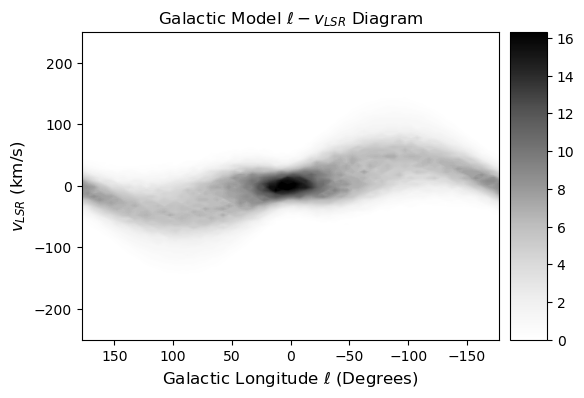

In [9]:
#########################################
#  CREATE THE PROFILES AND l-v DIAGRAM  #
#########################################

# Generate the default LV_diagram
lon, vel, dens_map = LVarray(rotvel_spline, density_spline)

# Generate plots
# (1) Generate plot of plot of the rotation curve of the Galaxy
# (2) Draw the density profile of the Galaxy
# (3) Using matplotlib to generate the l-v diagram, since bqplot doesn't seem cut out for it.
#
rot_curve = rotvel_plot(rad_spline, rotvel_spline)
density_profile = densprof_plot(rad_spline, density_spline)
lv_dia = widgets.Image(value=lv_plot(lon, vel, dens_map), format='png', width=600, height=400)

In [10]:
#
# Create Control Sliders/Fields/Buttons
#
sigma_label = widgets.Label(value='$\sigma_V$ (km/s): ')
sigma_slider = widgets.IntSlider(min=0, max=50, step=1, value=vel_sigma,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='02d',
                                 layout=widgets.Layout(height='75px', min_height='50px', max_height='100px',
                                                       min_width='50px', width='200px', max_width='300px',
                                                       overflow='hidden'))
sigma_control = widgets.HBox([sigma_label, sigma_slider], 
                             layout=widgets.Layout(align_content='center', align_items='center'))

imgfile_label = widgets.HTML(value='Image Filename: ', 
                             layout=widgets.Layout(min_width='70px', width='100px', max_width='200px'))
imgfile_name = widgets.Text(value=image_filename, 
                             layout=widgets.Layout(min_width='100px', width='200px', max_width='300px'))
imgfile_control = widgets.HBox([imgfile_label, imgfile_name], 
                               layout=widgets.Layout(align_content='center', align_items='center'))

savefile_button = widgets.Button(description='Save Plots', disabled=False,
                                 tooltip='Click to save image file',
                                 layout=widgets.Layout(min_width='100px', width='150px', max_width='200px'))

savelink = widgets.HTML(value='')

#
# Display the plots
#
settings_top = widgets.HBox([sigma_control, imgfile_control, savefile_button, savelink], 
                               layout=widgets.Layout(align_content='center', align_items='center',
                                                     margin='0px', width='850px', 
                                                     overflow='hidden'))
settings_bottom = widgets.HBox([rot_curve, density_profile], 
                            layout=widgets.Layout(margin='0px', width='850px', 
                                                  overflow='hidden'))
settings = widgets.VBox([settings_top, settings_bottom], 
                        layout=widgets.Layout(align_content='center', align_items='center',
                                              margin='0px', width='850px', 
                                              overflow='hidden'))
MainDisplay = widgets.VBox([settings, lv_dia], 
                           layout=widgets.Layout(align_content='center', align_items='center',
                                                 margin='0px', width='850px', 
                                                 overflow='hidden'))
display(MainDisplay)

#
# Direct functions to be called if various widgets change
#
sigma_slider.observe(sigma_changed, 'value')
rotcurve_spline.observe(update_rotcurve, names=['y'])
densprof_spline.observe(update_densprof, names=['y'])
savefile_button.on_click(make_printable_plot)